# Make extras figures (rivers, hydrothermal flux, etc.) and mesopelagic tracers

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci
import h5py as h5

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# regridding package
import xesmf as xe

# statistics package
import skill_metrics as sm


# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("h5py version =", h5.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("xesmf version =", xe.__version__)


wrkdir = "/g/data/es60/pjb581/liteexps"
os.chdir(wrkdir)



python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.1
xarray version = 2023.6.0
scipy version = 1.12.0
h5py version = 3.9.0
matplotlib version = 3.8.0
cmocean version = v3.0.3
cartopy version = 0.22.0
xesmf version = 0.8.5


## load the accessory input datasets

In [2]:
rivdic = xr.open_dataset("/g/data/es60/pjb581/wombat_files/mom_1deg_new/rivdic.nc")['rivdic'].squeeze()
rivdin = xr.open_dataset("/g/data/es60/pjb581/wombat_files/mom_1deg_new/rivdin.nc")['rivdin'].squeeze()
rivdon = xr.open_dataset("/g/data/es60/pjb581/wombat_files/mom_1deg_new/rivdon.nc")['rivdon'].squeeze()
hydrofe = xr.open_dataset("/g/data/es60/pjb581/wombat_files/mom_1deg_new/hydrofe.nc")['hydrofe'].squeeze()
dustfe = xr.open_dataset("/g/data/es60/pjb581/wombat_files/mom_1deg_new/dust.nc")['dust'].squeeze()

lon_mod = rivdic.coords['grid_x_T']
lat_mod = rivdic.coords['grid_y_T']
lons_mod, lats_mod = np.meshgrid(lon_mod.values, lat_mod.values)

vgrid  = xr.open_dataset("/g/data/es60/pjb581/wombat_files/ocean_vgrid.nc").rename({"zeta":"z", "nzv":"z"})
dep = vgrid['z'][1:-1:2]
dep_b = vgrid['z'][0::2]
dep_thick = dep_b[1::]-dep_b[0:-1]

dep_thick = dep_thick.rename({"z":"grid_z_T"})


In [3]:
inthydrofe = (hydrofe.mean(dim='time') * dep_thick).sum(dim='grid_z_T')

/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


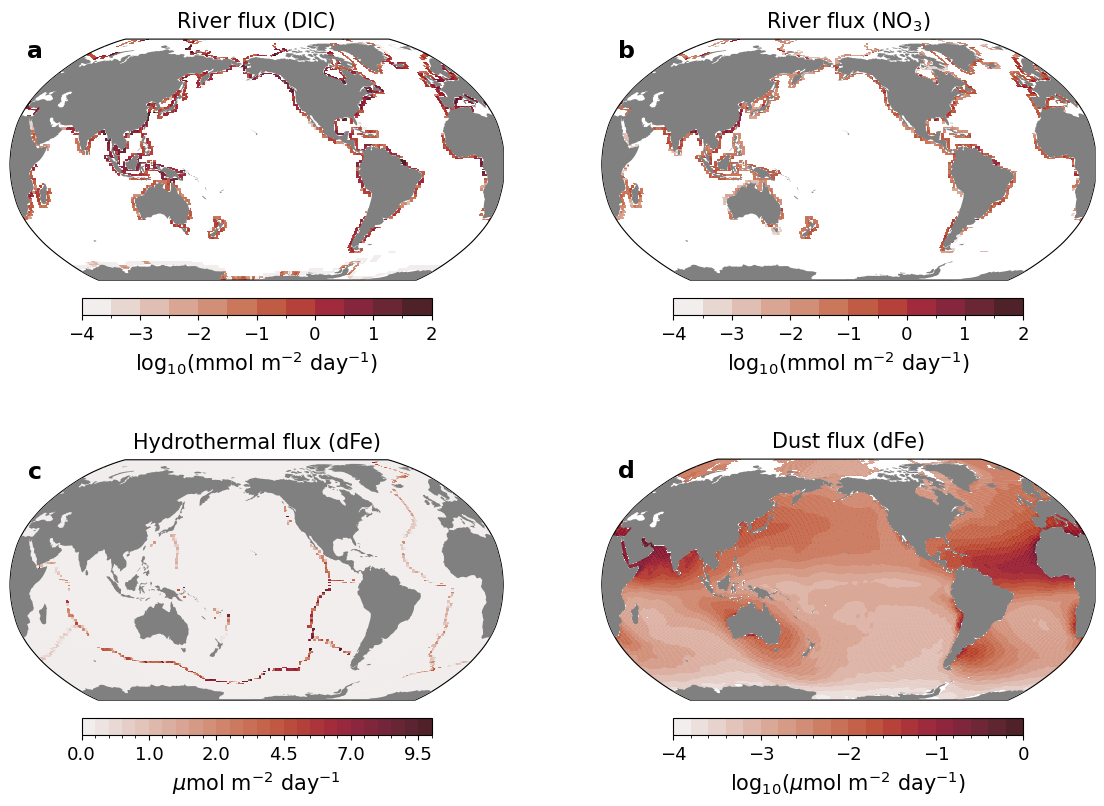

In [4]:
fslab = 15
fstic = 13

import matplotlib.lines as mlines
from cartopy.util import add_cyclic_point

proj = ccrs.Robinson(central_longitude=205)

colmap1 = lighten(cmo.amp, 0.9) #NO3
colmap2 = lighten(cmo.amp, 0.9) #NO3

levs1 = np.arange(-4,2.1,0.5)
norm1 = mcolors.BoundaryNorm(levs1, ncolors=256)

levs2 = np.concatenate(( np.arange(0,2,0.2), np.arange(2,10.1,0.5) ))
norm2 = mcolors.BoundaryNorm(levs2, ncolors=256)

levs3 = np.arange(-4.0,0.1,0.2)
norm3 = mcolors.BoundaryNorm(levs3, ncolors=256)

fig = plt.figure(figsize=(14,10), facecolor='w')
gs = GridSpec(2, 2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[1,0], projection=proj)
ax4 = plt.subplot(gs[1,1], projection=proj)

#p1 = ax1.contourf(lon_mod, lat_mod, np.log10(rivdic.mean(dim='time')*86400), transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='both')
#p2 = ax2.contourf(lon_mod, lat_mod, np.log10((rivdon+rivdin).mean(dim='time')*86400), transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='both')
#p3 = ax3.contourf(lon_mod, lat_mod, np.log10(inthydrofe*86400), transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='both')
#p4 = ax4.contourf(lon_mod, lat_mod, np.log10((rivdon+rivdin).mean(dim='time')*86400), transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='both')

p1 = ax1.pcolormesh(lon_mod, lat_mod, np.log10(rivdic.mean(dim='time')*86400), transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1)
p2 = ax2.pcolormesh(lon_mod, lat_mod, np.log10((rivdon+rivdin).mean(dim='time')*86400), transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1)
p3 = ax3.pcolormesh(lon_mod, lat_mod, inthydrofe*86400, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2)
p4 = ax4.pcolormesh(lon_mod, lat_mod, np.log10(dustfe.mean(dim='time')*86400), transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm3)

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
#ax1.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
#ax2.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax4.add_feature(cfeature.LAND, facecolor='grey', zorder=3)

plt.text(0.5, 1.075, 'River flux (DIC)', va='center', ha='center', fontsize=fslab, transform=ax1.transAxes)
plt.text(0.5, 1.075, 'River flux (NO$_3$)', va='center', ha='center', fontsize=fslab, transform=ax2.transAxes)
plt.text(0.5, 1.075, 'Hydrothermal flux (dFe)', va='center', ha='center', fontsize=fslab, transform=ax3.transAxes)
plt.text(0.5, 1.075, 'Dust flux (dFe)', va='center', ha='center', fontsize=fslab, transform=ax4.transAxes)

cbar1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=levs1[::2], fraction=0.05, pad=0.05)
cbar1.ax.tick_params(labelsize=fstic)
cbar1.ax.set_xlabel('log$_{10}$(mmol m$^{-2}$ day$^{-1}$)', fontsize=fslab)

cbar2 = plt.colorbar(p2, ax=ax2, orientation='horizontal', ticks=levs1[::2], fraction=0.05, pad=0.05)
cbar2.ax.tick_params(labelsize=fstic)
cbar2.ax.set_xlabel('log$_{10}$(mmol m$^{-2}$ day$^{-1}$)', fontsize=fslab)

cbar3 = plt.colorbar(p3, ax=ax3, orientation='horizontal', ticks=levs2[::5], fraction=0.05, pad=0.05)
cbar3.ax.tick_params(labelsize=fstic)
cbar3.ax.set_xlabel('$\mu$mol m$^{-2}$ day$^{-1}$', fontsize=fslab)

cbar4 = plt.colorbar(p4, ax=ax4, orientation='horizontal', ticks=levs3[::5], fraction=0.05, pad=0.05)
cbar4.ax.tick_params(labelsize=fstic)
cbar4.ax.set_xlabel('log$_{10}$($\mu$mol m$^{-2}$ day$^{-1}$)', fontsize=fslab)

xx = 0.05
yy = 0.95
plt.text(xx,yy, 'a', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, 'b', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax2.transAxes)
plt.text(xx,yy, 'c', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax3.transAxes)
plt.text(xx,yy, 'd', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax4.transAxes)


os.chdir(wrkdir)
fig.savefig("figures/extras.png", dpi=300)
fig.savefig("figures/extras.pdf", dpi=300)
fig.savefig("figures/extras_transparent.png", dpi=300, transparent=True)


## get the daily chlorophyll concentration data

In [5]:
os.getcwd()

'/g/data/es60/pjb581/liteexps'

In [6]:
no3_new = xr.open_dataset("./lite2optim21/oceanbgc-3d-no3-1-monthly-mean-y_1999.nc")['no3'].squeeze()
dfe_new = xr.open_dataset("./lite2optim21/oceanbgc-3d-fe-1-monthly-mean-y_1999.nc")['fe'].squeeze()
dic_new = xr.open_dataset("./lite2optim21/oceanbgc-3d-adic-1-monthly-mean-y_1999.nc")['adic'].squeeze()
alk_new = xr.open_dataset("./lite2optim21/oceanbgc-3d-alk-1-monthly-mean-y_1999.nc")['alk'].squeeze()
oxy_new = xr.open_dataset("./lite2optim21/oceanbgc-3d-o2-1-monthly-mean-y_1999.nc")['o2'].squeeze()

no3_old = xr.open_dataset("/g/data/es60/pjb581/biov3/oceanbgc-3d-no3-1-monthly-mean-y_1999.nc")['no3'].squeeze()
dfe_old = xr.open_dataset("/g/data/es60/pjb581/biov3/oceanbgc-3d-fe-1-monthly-mean-y_1999.nc")['fe'].squeeze()
dic_old = xr.open_dataset("/g/data/es60/pjb581/biov3/oceanbgc-3d-adic-1-monthly-mean-y_1999.nc")['adic'].squeeze()
alk_old = xr.open_dataset("/g/data/es60/pjb581/biov3/oceanbgc-3d-alk-1-monthly-mean-y_1999.nc")['alk'].squeeze()
oxy_old = xr.open_dataset("/g/data/es60/pjb581/biov3/oceanbgc-3d-o2-1-monthly-mean-y_1999.nc")['o2'].squeeze()


### observations

nan_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].squeeze()
n01_woa = xr.open_dataset("../../observations/woa23_all_n01_01.nc", decode_times=False)['n_an'].squeeze()
n02_woa = xr.open_dataset("../../observations/woa23_all_n02_01.nc", decode_times=False)['n_an'].squeeze()
n03_woa = xr.open_dataset("../../observations/woa23_all_n03_01.nc", decode_times=False)['n_an'].squeeze()
n04_woa = xr.open_dataset("../../observations/woa23_all_n04_01.nc", decode_times=False)['n_an'].squeeze()
n05_woa = xr.open_dataset("../../observations/woa23_all_n05_01.nc", decode_times=False)['n_an'].squeeze()
n06_woa = xr.open_dataset("../../observations/woa23_all_n06_01.nc", decode_times=False)['n_an'].squeeze()
n07_woa = xr.open_dataset("../../observations/woa23_all_n07_01.nc", decode_times=False)['n_an'].squeeze()
n08_woa = xr.open_dataset("../../observations/woa23_all_n08_01.nc", decode_times=False)['n_an'].squeeze()
n09_woa = xr.open_dataset("../../observations/woa23_all_n09_01.nc", decode_times=False)['n_an'].squeeze()
n10_woa = xr.open_dataset("../../observations/woa23_all_n10_01.nc", decode_times=False)['n_an'].squeeze()
n11_woa = xr.open_dataset("../../observations/woa23_all_n11_01.nc", decode_times=False)['n_an'].squeeze()
n12_woa = xr.open_dataset("../../observations/woa23_all_n12_01.nc", decode_times=False)['n_an'].squeeze()

oan_woa = xr.open_dataset("../../observations/woa23_all_o00_01.nc", decode_times=False)['o_an'].squeeze()
o01_woa = xr.open_dataset("../../observations/woa23_all_o01_01.nc", decode_times=False)['o_an'].squeeze()
o02_woa = xr.open_dataset("../../observations/woa23_all_o02_01.nc", decode_times=False)['o_an'].squeeze()
o03_woa = xr.open_dataset("../../observations/woa23_all_o03_01.nc", decode_times=False)['o_an'].squeeze()
o04_woa = xr.open_dataset("../../observations/woa23_all_o04_01.nc", decode_times=False)['o_an'].squeeze()
o05_woa = xr.open_dataset("../../observations/woa23_all_o05_01.nc", decode_times=False)['o_an'].squeeze()
o06_woa = xr.open_dataset("../../observations/woa23_all_o06_01.nc", decode_times=False)['o_an'].squeeze()
o07_woa = xr.open_dataset("../../observations/woa23_all_o07_01.nc", decode_times=False)['o_an'].squeeze()
o08_woa = xr.open_dataset("../../observations/woa23_all_o08_01.nc", decode_times=False)['o_an'].squeeze()
o09_woa = xr.open_dataset("../../observations/woa23_all_o09_01.nc", decode_times=False)['o_an'].squeeze()
o10_woa = xr.open_dataset("../../observations/woa23_all_o10_01.nc", decode_times=False)['o_an'].squeeze()
o11_woa = xr.open_dataset("../../observations/woa23_all_o11_01.nc", decode_times=False)['o_an'].squeeze()
o12_woa = xr.open_dataset("../../observations/woa23_all_o12_01.nc", decode_times=False)['o_an'].squeeze()

lon_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['lon']
lat_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['lat']
dep_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['depth']

no3_woa = xr.concat([n01_woa, n02_woa, n03_woa, n04_woa, n05_woa, n06_woa, n07_woa, n08_woa, n09_woa, n10_woa, n11_woa, n12_woa], dim="month")
nan_woa = xr.concat([nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa], dim="month")
no3_woa = no3_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
nan_woa = nan_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
no3_woa = xr.concat([no3_woa, nan_woa.isel(depth=slice(43,102))], dim='depth')

oxy_woa = xr.concat([o01_woa, o02_woa, o03_woa, o04_woa, o05_woa, o06_woa, o07_woa, o08_woa, o09_woa, o10_woa, o11_woa, o12_woa], dim="month")
oan_woa = xr.concat([oan_woa, oan_woa, oan_woa, oan_woa, oan_woa, oan_woa, oan_woa, oan_woa, oan_woa, oan_woa, oan_woa, oan_woa], dim="month")
oxy_woa = oxy_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
oan_woa = oan_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
oxy_woa = xr.concat([oxy_woa, oan_woa.isel(depth=slice(57,102))], dim='depth')

woa_lons, woa_lats = np.meshgrid(no3_woa.coords['lon'], no3_woa.coords['lat'])

del n01_woa, n02_woa, n03_woa, n04_woa, n05_woa, n06_woa, n07_woa, n08_woa, n09_woa, n10_woa, n11_woa, n12_woa, nan_woa
del o01_woa, o02_woa, o03_woa, o04_woa, o05_woa, o06_woa, o07_woa, o08_woa, o09_woa, o10_woa, o11_woa, o12_woa, oan_woa

dic_obs = xr.open_dataset("/g/data/es60/observations/GLODAPv2.2016b.PI_TCO2.nc", decode_times=False)['PI_TCO2'].squeeze()
alk_obs = xr.open_dataset("/g/data/es60/observations/GLODAPv2.2016b.TAlk.nc", decode_times=False)['TAlk'].squeeze()

glodap_deps = xr.open_dataset("/g/data/es60/observations/GLODAPv2.2016b.PI_TCO2.nc", decode_times=False)['Depth'].squeeze()
glodap_lons, glodap_lats = np.meshgrid(dic_obs.coords['lon'], dic_obs.coords['lat'])

# Dissolved Iron (Huang, Y.,Tagliabue, A., & Cassar, N. (2022). Data-driven modeling of dissolved iron in the global ocean. Frontier in Marine Science))
dfe_Huang = xr.open_dataset("../../observations/Monthly_dFe.nc")['dFe_RF']
dfe_Huang = dfe_Huang.isel(Month=slice(0,12)).rename({"Month":"month", "Depth":"depth"})
lon_Huang = dfe_Huang.coords['Longitude']
lat_Huang = dfe_Huang.coords['Latitude']


/jobfs/130474645.gadi-pbs/ipykernel_1060293/2506168657.py:50: UserWarning: rename 'time' to 'month' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  no3_woa = no3_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
/jobfs/130474645.gadi-pbs/ipykernel_1060293/2506168657.py:56: UserWarning: rename 'time' to 'month' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  oxy_woa = oxy_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})


In [7]:
ds_out = xe.util.grid_global(1,1)
lon_reg = ds_out.coords['lon']
lat_reg = ds_out.coords['lat']


print("Regridding model")
ds_in = xr.Dataset(
    {'no3_new_500m': ( ('month', 'y', 'x'), no3_new.isel(st_ocean=23).values),
     'no3_new_1000m': ( ('month', 'y', 'x'), no3_new.isel(st_ocean=28).values),
     'no3_old_500m': ( ('month', 'y', 'x'), no3_old.isel(st_ocean=23).values),
     'no3_old_1000m': ( ('month', 'y', 'x'), no3_old.isel(st_ocean=28).values),
     'dfe_new_500m': ( ('month', 'y', 'x'), dfe_new.isel(st_ocean=23).values),
     'dfe_new_1000m': ( ('month', 'y', 'x'), dfe_new.isel(st_ocean=28).values),
     'dfe_old_500m': ( ('month', 'y', 'x'), dfe_old.isel(st_ocean=23).values),
     'dfe_old_1000m': ( ('month', 'y', 'x'), dfe_old.isel(st_ocean=28).values),
     'oxy_new_500m': ( ('month', 'y', 'x'), oxy_new.isel(st_ocean=23).values),
     'oxy_new_1000m': ( ('month', 'y', 'x'), oxy_new.isel(st_ocean=28).values),
     'oxy_old_500m': ( ('month', 'y', 'x'), oxy_old.isel(st_ocean=23).values),
     'oxy_old_1000m': ( ('month', 'y', 'x'), oxy_old.isel(st_ocean=28).values),
     'dic_new_500m': ( ('month', 'y', 'x'), dic_new.isel(st_ocean=23).values),
     'dic_new_1000m': ( ('month', 'y', 'x'), dic_new.isel(st_ocean=28).values),
     'dic_old_500m': ( ('month', 'y', 'x'), dic_old.isel(st_ocean=23).values),
     'dic_old_1000m': ( ('month', 'y', 'x'), dic_old.isel(st_ocean=28).values),
     'alk_new_500m': ( ('month', 'y', 'x'), alk_new.isel(st_ocean=23).values),
     'alk_new_1000m': ( ('month', 'y', 'x'), alk_new.isel(st_ocean=28).values),
     'alk_old_500m': ( ('month', 'y', 'x'), alk_old.isel(st_ocean=23).values),
     'alk_old_1000m': ( ('month', 'y', 'x'), alk_old.isel(st_ocean=28).values),
    },
    coords={"lon": (['y','x'], lons_mod),
            "lat": (['y','x'], lats_mod),
            "month": (['month'], no3_new.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
no3_new_500m = regridder(ds_in['no3_new_500m'])
no3_new_1000m = regridder(ds_in['no3_new_1000m'])
no3_old_500m = regridder(ds_in['no3_old_500m'])
no3_old_1000m = regridder(ds_in['no3_old_1000m'])
dfe_new_500m = regridder(ds_in['dfe_new_500m'])
dfe_new_1000m = regridder(ds_in['dfe_new_1000m'])
dfe_old_500m = regridder(ds_in['dfe_old_500m'])
dfe_old_1000m = regridder(ds_in['dfe_old_1000m'])
oxy_new_500m = regridder(ds_in['oxy_new_500m'])
oxy_new_1000m = regridder(ds_in['oxy_new_1000m'])
oxy_old_500m = regridder(ds_in['oxy_old_500m'])
oxy_old_1000m = regridder(ds_in['oxy_old_1000m'])
dic_new_500m = regridder(ds_in['dic_new_500m'])
dic_new_1000m = regridder(ds_in['dic_new_1000m'])
dic_old_500m = regridder(ds_in['dic_old_500m'])
dic_old_1000m = regridder(ds_in['dic_old_1000m'])
alk_new_500m = regridder(ds_in['alk_new_500m'])
alk_new_1000m = regridder(ds_in['alk_new_1000m'])
alk_old_500m = regridder(ds_in['alk_old_500m'])
alk_old_1000m = regridder(ds_in['alk_old_1000m'])

print("Regridding WOA")
ds_in = xr.Dataset(
    {'no3_obs_500m': ( ('month', 'y', 'x'), no3_woa.isel(depth=36).values),
     'no3_obs_1000m': ( ('month', 'y', 'x'), no3_woa.isel(depth=46).values),
     'oxy_obs_500m': ( ('month', 'y', 'x'), oxy_woa.isel(depth=36).values),
     'oxy_obs_1000m': ( ('month', 'y', 'x'), oxy_woa.isel(depth=46).values),
     },
    coords={"lon": (['y','x'], woa_lons),
            "lat": (['y','x'], woa_lats),
            "month": (['month'], no3_new.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
no3_obs_500m = regridder(ds_in['no3_obs_500m'])
no3_obs_1000m = regridder(ds_in['no3_obs_1000m'])
oxy_obs_500m = regridder(ds_in['oxy_obs_500m'])
oxy_obs_1000m = regridder(ds_in['oxy_obs_1000m'])


print("Regridding GLODAP")
ds_in = xr.Dataset(
    {'dic_obs_500m': ( ('y', 'x'), dic_obs.isel(depth_surface=13).values),
     'dic_obs_1000m': ( ('y', 'x'), dic_obs.isel(depth_surface=18).values),
     'alk_obs_500m': ( ('y', 'x'), alk_obs.isel(depth_surface=13).values),
     'alk_obs_1000m': ( ('y', 'x'), alk_obs.isel(depth_surface=18).values),
    },
    coords={"lon": (['y','x'], glodap_lons),
            "lat": (['y','x'], glodap_lats),
            }
    )    
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
dic_obs_500m = regridder(ds_in['dic_obs_500m'])
dic_obs_1000m = regridder(ds_in['dic_obs_1000m'])
alk_obs_500m = regridder(ds_in['alk_obs_500m'])
alk_obs_1000m = regridder(ds_in['alk_obs_1000m'])

print("Regridding Huang data")
lon_Huang, lat_Huang = np.meshgrid(lon_Huang, lat_Huang)
ds_in = xr.Dataset(
    {'dfe_obs_500m': ( ('month', 'y', 'x'), dfe_Huang.isel(depth=19).values),
     'dfe_obs_1000m': ( ('month', 'y', 'x'), dfe_Huang.isel(depth=21).values),
     },
    coords={"lon": (['y','x'], lon_Huang),
            "lat": (['y','x'], lat_Huang),
            "month": (['month'], dfe_Huang.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
dfe_obs_500m = regridder(ds_in['dfe_obs_500m'])
dfe_obs_1000m = regridder(ds_in['dfe_obs_1000m'])


Regridding model
Regridding WOA


/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/g/data/es60/pjb581/miniforge3/envs/model_assessment_env/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Regridding GLODAP
Regridding Huang data


## add cyclic point

In [8]:
ds_mod = xr.Dataset(
    {'no3_new_500m': ( ('month', 'y', 'x'), no3_new_500m.values),
     'no3_new_1000m': ( ('month', 'y', 'x'), no3_new_1000m.values),
     'no3_old_500m': ( ('month', 'y', 'x'), no3_old_500m.values),
     'no3_old_1000m': ( ('month', 'y', 'x'), no3_old_1000m.values),
     'dfe_new_500m': ( ('month', 'y', 'x'), dfe_new_500m.values),
     'dfe_new_1000m': ( ('month', 'y', 'x'), dfe_new_1000m.values),
     'dfe_old_500m': ( ('month', 'y', 'x'), dfe_old_500m.values),
     'dfe_old_1000m': ( ('month', 'y', 'x'), dfe_old_1000m.values),
     'oxy_new_500m': ( ('month', 'y', 'x'), oxy_new_500m.values),
     'oxy_new_1000m': ( ('month', 'y', 'x'), oxy_new_1000m.values),
     'oxy_old_500m': ( ('month', 'y', 'x'), oxy_old_500m.values),
     'oxy_old_1000m': ( ('month', 'y', 'x'), oxy_old_1000m.values),
     'dic_new_500m': ( ('month', 'y', 'x'), dic_new_500m.values),
     'dic_new_1000m': ( ('month', 'y', 'x'), dic_new_1000m.values),
     'dic_old_500m': ( ('month', 'y', 'x'), dic_old_500m.values),
     'dic_old_1000m': ( ('month', 'y', 'x'), dic_old_1000m.values),
     'alk_new_500m': ( ('month', 'y', 'x'), alk_new_500m.values),
     'alk_new_1000m': ( ('month', 'y', 'x'), alk_new_1000m.values),
     'alk_old_500m': ( ('month', 'y', 'x'), alk_old_500m.values),
     'alk_old_1000m': ( ('month', 'y', 'x'), alk_old_1000m.values),
     },
    coords={"lon": (['x'], lon_reg.isel(y=0).values),
            "lat": (['y'], lat_reg.isel(x=0).values),
            "month": (['month'], no3_woa.coords['month'].values),
           }
)

ds_obs = xr.Dataset(
    {'no3_obs_500m': ( ('month', 'y', 'x'), no3_obs_500m.values),
     'no3_obs_1000m': ( ('month', 'y', 'x'), no3_obs_1000m.values),
     'dfe_obs_500m': ( ('month', 'y', 'x'), dfe_obs_500m.values),
     'dfe_obs_1000m': ( ('month', 'y', 'x'), dfe_obs_1000m.values),
     'oxy_obs_500m': ( ('month', 'y', 'x'), oxy_obs_500m.values),
     'oxy_obs_1000m': ( ('month', 'y', 'x'), oxy_obs_1000m.values),
     'dic_obs_500m': ( ('y', 'x'), dic_obs_500m.values),
     'dic_obs_1000m': ( ('y', 'x'), dic_obs_1000m.values),
     'alk_obs_500m': ( ('y', 'x'), alk_obs_500m.values),
     'alk_obs_1000m': ( ('y', 'x'), alk_obs_1000m.values),
     },
    coords={"lon": (['x'], lon_reg.isel(y=0).values),
            "lat": (['y'], lat_reg.isel(x=0).values),
            "month": (['month'], no3_woa.coords['month'].values),
           }
)

print("adding cyclic point")
from cartopy.util import add_cyclic_point

no3_new_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['no3_new_500m'].mean(dim='month'), coord=ds_mod['no3_old_500m'].coords['lon'])
no3_new_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['no3_new_1000m'].mean(dim='month'), coord=ds_mod['no3_old_1000m'].coords['lon'])
no3_old_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['no3_old_500m'].mean(dim='month'), coord=ds_mod['no3_old_500m'].coords['lon'])
no3_old_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['no3_old_1000m'].mean(dim='month'), coord=ds_mod['no3_old_1000m'].coords['lon'])

dfe_new_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['dfe_new_500m'].mean(dim='month'), coord=ds_mod['dfe_old_500m'].coords['lon'])
dfe_new_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['dfe_new_1000m'].mean(dim='month'), coord=ds_mod['dfe_old_1000m'].coords['lon'])
dfe_old_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['dfe_old_500m'].mean(dim='month'), coord=ds_mod['dfe_old_500m'].coords['lon'])
dfe_old_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['dfe_old_1000m'].mean(dim='month'), coord=ds_mod['dfe_old_1000m'].coords['lon'])

oxy_new_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['oxy_new_500m'].mean(dim='month'), coord=ds_mod['no3_old_500m'].coords['lon'])
oxy_new_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['oxy_new_1000m'].mean(dim='month'), coord=ds_mod['no3_old_1000m'].coords['lon'])
oxy_old_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['oxy_old_500m'].mean(dim='month'), coord=ds_mod['no3_old_500m'].coords['lon'])
oxy_old_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['oxy_old_1000m'].mean(dim='month'), coord=ds_mod['no3_old_1000m'].coords['lon'])

dic_new_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['dic_new_500m'].mean(dim='month'), coord=ds_mod['no3_old_500m'].coords['lon'])
dic_new_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['dic_new_1000m'].mean(dim='month'), coord=ds_mod['no3_old_1000m'].coords['lon'])
dic_old_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['dic_old_500m'].mean(dim='month'), coord=ds_mod['no3_old_500m'].coords['lon'])
dic_old_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['dic_old_1000m'].mean(dim='month'), coord=ds_mod['no3_old_1000m'].coords['lon'])

alk_new_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['alk_new_500m'].mean(dim='month'), coord=ds_mod['no3_old_500m'].coords['lon'])
alk_new_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['alk_new_1000m'].mean(dim='month'), coord=ds_mod['no3_old_1000m'].coords['lon'])
alk_old_500m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['alk_old_500m'].mean(dim='month'), coord=ds_mod['no3_old_500m'].coords['lon'])
alk_old_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_mod['alk_old_1000m'].mean(dim='month'), coord=ds_mod['no3_old_1000m'].coords['lon'])


no3_obs_500m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['no3_obs_500m'].mean(dim='month'), coord=ds_obs['no3_obs_500m'].coords['lon'])
no3_obs_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['no3_obs_1000m'].mean(dim='month'), coord=ds_obs['no3_obs_1000m'].coords['lon'])

dfe_obs_500m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['dfe_obs_500m'].mean(dim='month'), coord=ds_obs['dfe_obs_500m'].coords['lon'])
dfe_obs_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['dfe_obs_1000m'].mean(dim='month'), coord=ds_obs['dfe_obs_1000m'].coords['lon'])

oxy_obs_500m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['oxy_obs_500m'].mean(dim='month'), coord=ds_obs['no3_obs_500m'].coords['lon'])
oxy_obs_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['oxy_obs_1000m'].mean(dim='month'), coord=ds_obs['no3_obs_1000m'].coords['lon'])

dic_obs_500m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['dic_obs_500m'], coord=ds_obs['no3_obs_500m'].coords['lon'])
dic_obs_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['dic_obs_1000m'], coord=ds_obs['no3_obs_1000m'].coords['lon'])

alk_obs_500m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['alk_obs_500m'], coord=ds_obs['no3_obs_500m'].coords['lon'])
alk_obs_1000m_cyclic, lon_cyclic = add_cyclic_point(ds_obs['alk_obs_1000m'], coord=ds_obs['no3_obs_1000m'].coords['lon'])


adding cyclic point


In [9]:
levs2

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,
        8. ,  8.5,  9. ,  9.5, 10. ])

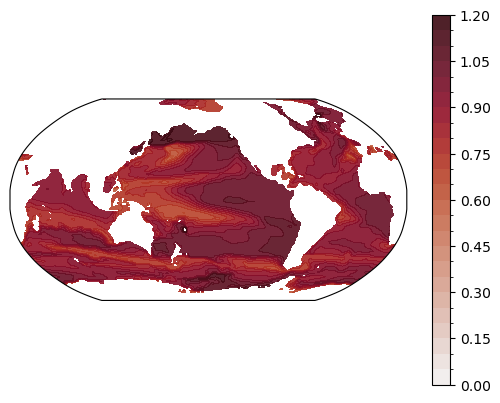

In [10]:
levs2 = np.arange(0,121,5)*0.01
norm2 = mcolors.BoundaryNorm(levs2, ncolors=256)

fig = plt.figure()
gs = GridSpec(1,1)
ax = plt.subplot(gs[0], projection=proj)

p1 = ax.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_new_500m_cyclic+1e-2, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2)
plt.colorbar(p1)


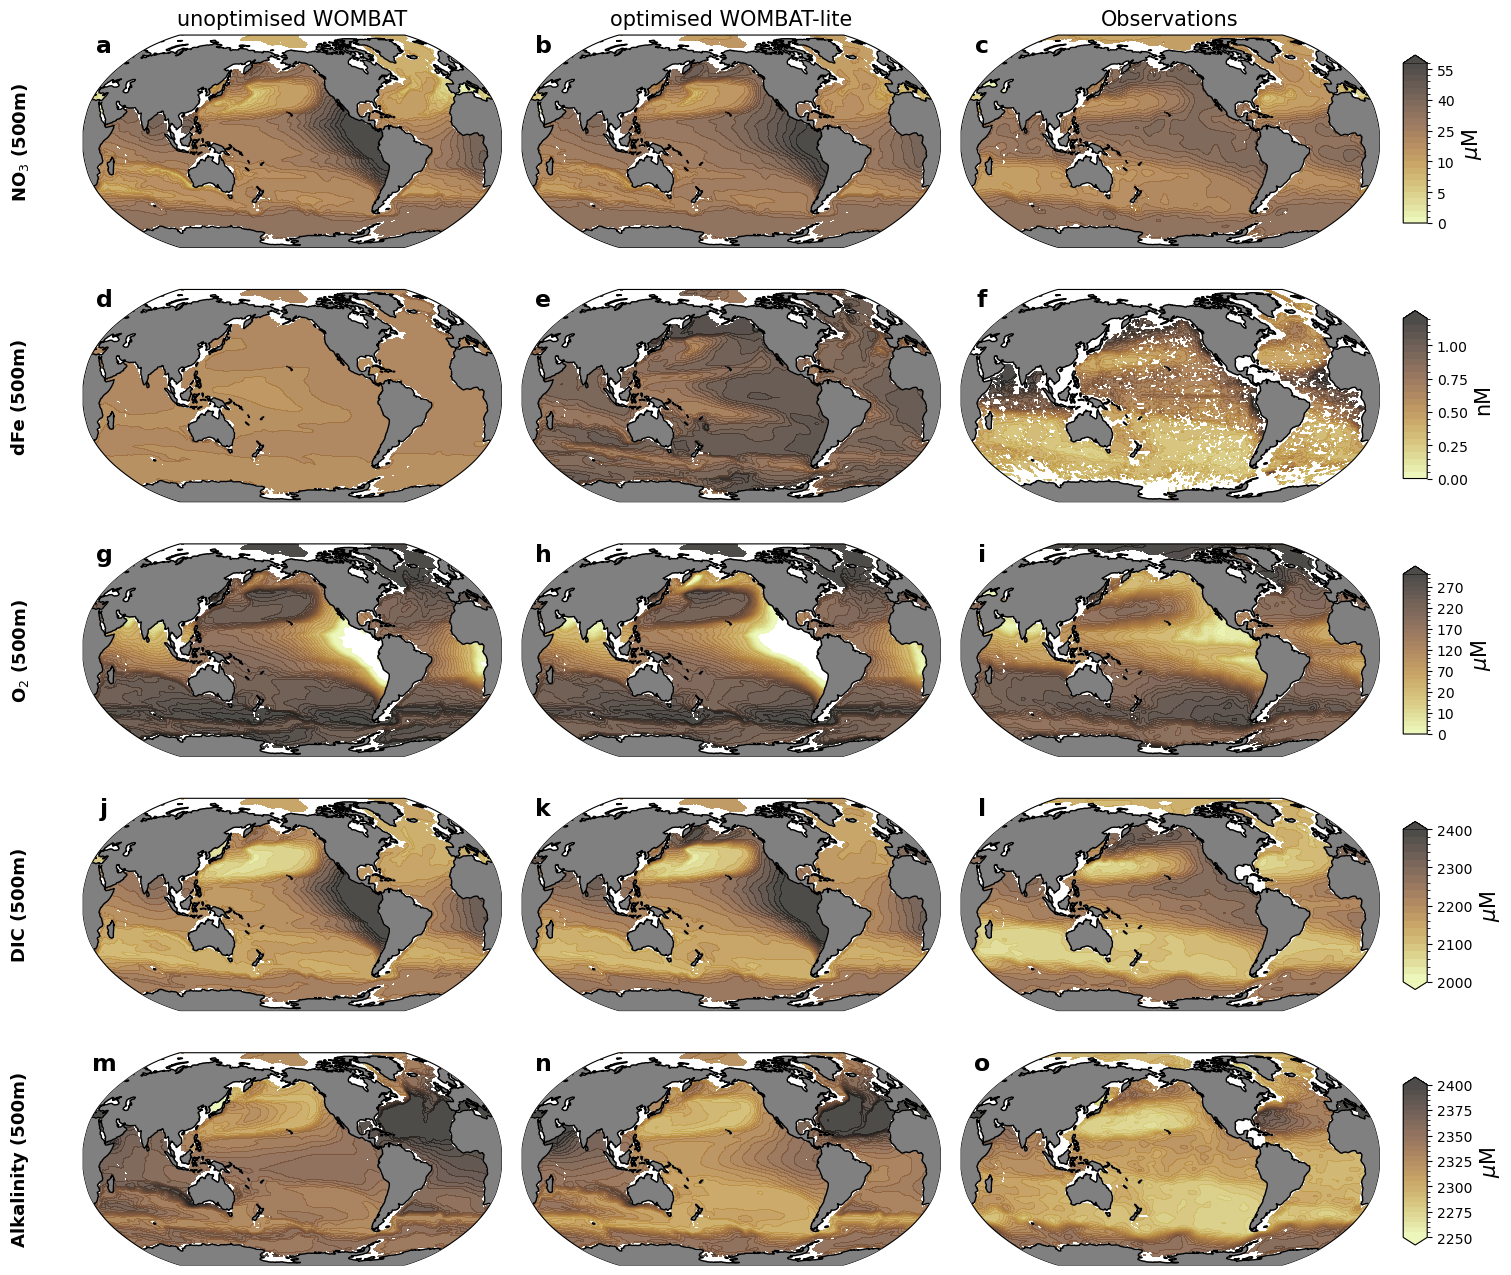

In [11]:
fslab = 15
fstic = 13

import matplotlib.lines as mlines
from cartopy.util import add_cyclic_point

proj = ccrs.Robinson(central_longitude=205)

colmap1 = lighten(cmo.turbid, 0.8) #NO3
colmap2 = lighten(cmo.turbid, 0.8) #dFe
colmap3 = lighten(cmo.turbid, 0.8) #O2
colmap4 = lighten(cmo.turbid, 0.8) #DIC
colmap5 = lighten(cmo.turbid, 0.8) #Alk

# NO3
levs1 = np.concatenate( (np.arange(0,10,1), np.arange(10,61,3)) )
norm1 = mcolors.BoundaryNorm(levs1, ncolors=256)

# dFe
levs2 = np.concatenate( (np.arange(0,10,2), np.arange(10,121,10)) )*0.01
levs2 = np.arange(0,121,5)*0.01
norm2 = mcolors.BoundaryNorm(levs2, ncolors=256)

# O2
levs3 = np.concatenate( (np.arange(0,20,2), np.arange(20,301,10)) )
norm3 = mcolors.BoundaryNorm(levs3, ncolors=256)

# DIC
levs4 = np.arange(2000, 2401, 20)
norm4 = mcolors.BoundaryNorm(levs4, ncolors=256)

# Alkalinity
levs5 = np.arange(2250,2401,5)
norm5 = mcolors.BoundaryNorm(levs5, ncolors=256)


fig = plt.figure(figsize=(16,14), facecolor='w')
gs = GridSpec(5, 3)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[0,2], projection=proj)
ax4 = plt.subplot(gs[1,0], projection=proj)
ax5 = plt.subplot(gs[1,1], projection=proj)
ax6 = plt.subplot(gs[1,2], projection=proj)
ax7 = plt.subplot(gs[2,0], projection=proj)
ax8 = plt.subplot(gs[2,1], projection=proj)
ax9 = plt.subplot(gs[2,2], projection=proj)
ax10 = plt.subplot(gs[3,0], projection=proj)
ax11 = plt.subplot(gs[3,1], projection=proj)
ax12 = plt.subplot(gs[3,2], projection=proj)
ax13 = plt.subplot(gs[4,0], projection=proj)
ax14 = plt.subplot(gs[4,1], projection=proj)
ax15 = plt.subplot(gs[4,2], projection=proj)


p1 = ax1.contourf(lon_cyclic, lat_reg.isel(x=0), no3_old_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')
p2 = ax2.contourf(lon_cyclic, lat_reg.isel(x=0), no3_new_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')
p3 = ax3.contourf(lon_cyclic, lat_reg.isel(x=0), no3_obs_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')

p4 = ax4.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_old_500m_cyclic+1e-2, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='max')
p5 = ax5.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_new_500m_cyclic+1e-2, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='max')
p6 = ax6.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_obs_500m_cyclic+1e-2, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='max')

p7 = ax7.contourf(lon_cyclic, lat_reg.isel(x=0), oxy_old_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')
p8 = ax8.contourf(lon_cyclic, lat_reg.isel(x=0), oxy_new_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')
p9 = ax9.contourf(lon_cyclic, lat_reg.isel(x=0), oxy_obs_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')

p10 = ax10.contourf(lon_cyclic, lat_reg.isel(x=0), dic_old_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='both')
p11 = ax11.contourf(lon_cyclic, lat_reg.isel(x=0), dic_new_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='both')
p12 = ax12.contourf(lon_cyclic, lat_reg.isel(x=0), dic_obs_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='both')

p13 = ax13.contourf(lon_cyclic, lat_reg.isel(x=0), alk_old_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')
p14 = ax14.contourf(lon_cyclic, lat_reg.isel(x=0), alk_new_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')
p15 = ax15.contourf(lon_cyclic, lat_reg.isel(x=0), alk_obs_500m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax2.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax3.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax4.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax4.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax9.add_feature(cfeature.LAND, color='grey', zorder=3)
ax9.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax12.add_feature(cfeature.LAND, color='grey', zorder=3)
ax12.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax13.add_feature(cfeature.LAND, color='grey', zorder=3)
ax13.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax14.add_feature(cfeature.LAND, color='grey', zorder=3)
ax14.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax15.add_feature(cfeature.LAND, color='grey', zorder=3)
ax15.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)

xx = -0.15; yy = 0.5
plt.text(xx,yy, 'NO$_3$ (500m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax1.transAxes)
plt.text(xx,yy, 'dFe (500m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax4.transAxes)
plt.text(xx,yy, 'O$_2$ (500m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax7.transAxes)
plt.text(xx,yy, 'DIC (500m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax10.transAxes)
plt.text(xx,yy, 'Alkalinity (500m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax13.transAxes)

plt.text(0.5, 1.075, 'unoptimised WOMBAT', va='center', ha='center', fontsize=fslab, transform=ax1.transAxes)
plt.text(0.5, 1.075, 'optimised WOMBAT-lite', va='center', ha='center', fontsize=fslab, transform=ax2.transAxes)
plt.text(0.5, 1.075, 'Observations', va='center', ha='center', fontsize=fslab, transform=ax3.transAxes)

plt.subplots_adjust(left=0.075, bottom=0.05, top=0.95, right=0.885, hspace=0.05, wspace=0.05)

cbax1 = fig.add_axes([0.9, 0.8050, 0.015, 0.12])
cbax2 = fig.add_axes([0.9, 0.6225, 0.015, 0.12])
cbax3 = fig.add_axes([0.9, 0.4400, 0.015, 0.12])
cbax4 = fig.add_axes([0.9, 0.2575, 0.015, 0.12])
cbax5 = fig.add_axes([0.9, 0.0750, 0.015, 0.12])

cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::5])
cbar2 = plt.colorbar(p4, cax=cbax2, orientation='vertical', ticks=levs2[::5])
cbar3 = plt.colorbar(p7, cax=cbax3, orientation='vertical', ticks=levs3[::5])
cbar4 = plt.colorbar(p10, cax=cbax4, orientation='vertical', ticks=levs4[::5])
cbar5 = plt.colorbar(p13, cax=cbax5, orientation='vertical', ticks=levs5[::5])

cbar1.ax.set_ylabel('$\mu$M', fontsize=fslab)
cbar2.ax.set_ylabel('nM', fontsize=fslab)
cbar3.ax.set_ylabel('$\mu$M', fontsize=fslab)
cbar4.ax.set_ylabel('$\mu$M', fontsize=fslab)
cbar5.ax.set_ylabel('$\mu$M', fontsize=fslab)

xx = 0.05
yy = 0.95
plt.text(xx,yy, 'a', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, 'b', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax2.transAxes)
plt.text(xx,yy, 'c', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax3.transAxes)
plt.text(xx,yy, 'd', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax4.transAxes)
plt.text(xx,yy, 'e', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax5.transAxes)
plt.text(xx,yy, 'f', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax6.transAxes)
plt.text(xx,yy, 'g', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax7.transAxes)
plt.text(xx,yy, 'h', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax8.transAxes)
plt.text(xx,yy, 'i', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax9.transAxes)
plt.text(xx,yy, 'j', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax10.transAxes)
plt.text(xx,yy, 'k', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax11.transAxes)
plt.text(xx,yy, 'l', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax12.transAxes)
plt.text(xx,yy, 'm', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax13.transAxes)
plt.text(xx,yy, 'n', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax14.transAxes)
plt.text(xx,yy, 'o', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax15.transAxes)


os.chdir(wrkdir)
fig.savefig("figures/section3.4-tracerdistributions_500m.png", dpi=300)
fig.savefig("figures/section3.4-tracerdistributions_500m.pdf", dpi=300)
fig.savefig("figures/section3.4-tracerdistributions_500m_transparent.png", dpi=300, transparent=True)


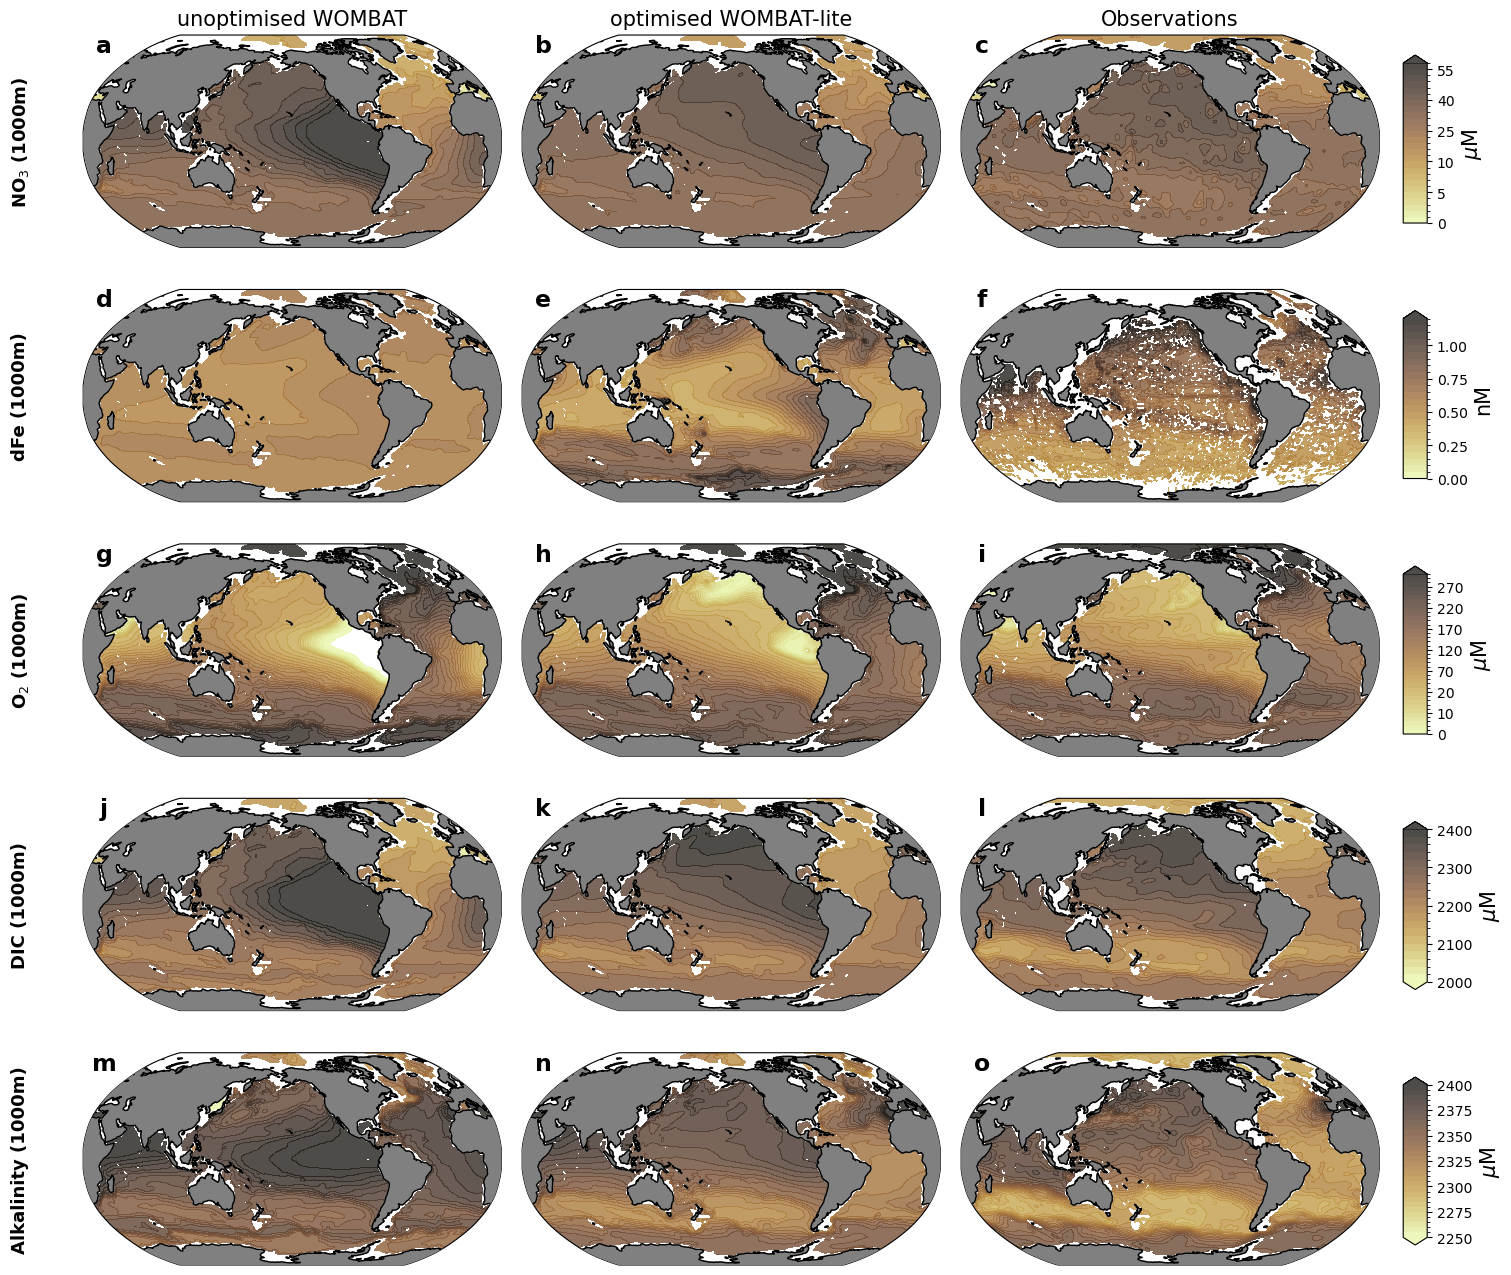

In [12]:
fslab = 15
fstic = 13

import matplotlib.lines as mlines
from cartopy.util import add_cyclic_point

proj = ccrs.Robinson(central_longitude=205)

colmap1 = lighten(cmo.turbid, 0.8) #NO3
colmap2 = lighten(cmo.turbid, 0.8) #dFe
colmap3 = lighten(cmo.turbid, 0.8) #O2
colmap4 = lighten(cmo.turbid, 0.8) #DIC
colmap5 = lighten(cmo.turbid, 0.8) #Alk

# NO3
levs1 = np.concatenate( (np.arange(0,10,1), np.arange(10,61,3)) )
norm1 = mcolors.BoundaryNorm(levs1, ncolors=256)

# dFe
levs2 = np.concatenate( (np.arange(0,10,2), np.arange(10,121,10)) )*0.01
levs2 = np.arange(0,121,5)*0.01
norm2 = mcolors.BoundaryNorm(levs2, ncolors=256)

# O2
levs3 = np.concatenate( (np.arange(0,20,2), np.arange(20,301,10)) )
norm3 = mcolors.BoundaryNorm(levs3, ncolors=256)

# DIC
levs4 = np.arange(2000, 2401, 20)
norm4 = mcolors.BoundaryNorm(levs4, ncolors=256)

# Alkalinity
levs5 = np.arange(2250,2401,5)
norm5 = mcolors.BoundaryNorm(levs5, ncolors=256)


fig = plt.figure(figsize=(16,14), facecolor='w')
gs = GridSpec(5, 3)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[0,2], projection=proj)
ax4 = plt.subplot(gs[1,0], projection=proj)
ax5 = plt.subplot(gs[1,1], projection=proj)
ax6 = plt.subplot(gs[1,2], projection=proj)
ax7 = plt.subplot(gs[2,0], projection=proj)
ax8 = plt.subplot(gs[2,1], projection=proj)
ax9 = plt.subplot(gs[2,2], projection=proj)
ax10 = plt.subplot(gs[3,0], projection=proj)
ax11 = plt.subplot(gs[3,1], projection=proj)
ax12 = plt.subplot(gs[3,2], projection=proj)
ax13 = plt.subplot(gs[4,0], projection=proj)
ax14 = plt.subplot(gs[4,1], projection=proj)
ax15 = plt.subplot(gs[4,2], projection=proj)


p1 = ax1.contourf(lon_cyclic, lat_reg.isel(x=0), no3_old_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')
p2 = ax2.contourf(lon_cyclic, lat_reg.isel(x=0), no3_new_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')
p3 = ax3.contourf(lon_cyclic, lat_reg.isel(x=0), no3_obs_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap1, norm=norm1, levels=levs1, extend='max')

p4 = ax4.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_old_1000m_cyclic+1e-2, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='max')
p5 = ax5.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_new_1000m_cyclic+1e-2, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='max')
p6 = ax6.contourf(lon_cyclic, lat_reg.isel(x=0), dfe_obs_1000m_cyclic+1e-2, transform=ccrs.PlateCarree(), cmap=colmap2, norm=norm2, levels=levs2, extend='max')

p7 = ax7.contourf(lon_cyclic, lat_reg.isel(x=0), oxy_old_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')
p8 = ax8.contourf(lon_cyclic, lat_reg.isel(x=0), oxy_new_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')
p9 = ax9.contourf(lon_cyclic, lat_reg.isel(x=0), oxy_obs_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap3, norm=norm3, levels=levs3, extend='max')

p10 = ax10.contourf(lon_cyclic, lat_reg.isel(x=0), dic_old_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='both')
p11 = ax11.contourf(lon_cyclic, lat_reg.isel(x=0), dic_new_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='both')
p12 = ax12.contourf(lon_cyclic, lat_reg.isel(x=0), dic_obs_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap4, norm=norm4, levels=levs4, extend='both')

p13 = ax13.contourf(lon_cyclic, lat_reg.isel(x=0), alk_old_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')
p14 = ax14.contourf(lon_cyclic, lat_reg.isel(x=0), alk_new_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')
p15 = ax15.contourf(lon_cyclic, lat_reg.isel(x=0), alk_obs_1000m_cyclic, transform=ccrs.PlateCarree(), cmap=colmap5, norm=norm5, levels=levs5, extend='both')

ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax1.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax2.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax3.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax4.add_feature(cfeature.LAND, facecolor='grey', zorder=3)
ax4.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax9.add_feature(cfeature.LAND, color='grey', zorder=3)
ax9.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax12.add_feature(cfeature.LAND, color='grey', zorder=3)
ax12.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax13.add_feature(cfeature.LAND, color='grey', zorder=3)
ax13.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax14.add_feature(cfeature.LAND, color='grey', zorder=3)
ax14.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)
ax15.add_feature(cfeature.LAND, color='grey', zorder=3)
ax15.add_feature(cfeature.COASTLINE, edgecolor='k', zorder=4)

xx = -0.15; yy = 0.5
plt.text(xx,yy, 'NO$_3$ (1000m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax1.transAxes)
plt.text(xx,yy, 'dFe (1000m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax4.transAxes)
plt.text(xx,yy, 'O$_2$ (1000m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax7.transAxes)
plt.text(xx,yy, 'DIC (1000m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax10.transAxes)
plt.text(xx,yy, 'Alkalinity (1000m)', ha='center', va='center', fontweight='bold', fontsize=fstic, rotation=90, transform=ax13.transAxes)

plt.text(0.5, 1.075, 'unoptimised WOMBAT', va='center', ha='center', fontsize=fslab, transform=ax1.transAxes)
plt.text(0.5, 1.075, 'optimised WOMBAT-lite', va='center', ha='center', fontsize=fslab, transform=ax2.transAxes)
plt.text(0.5, 1.075, 'Observations', va='center', ha='center', fontsize=fslab, transform=ax3.transAxes)

plt.subplots_adjust(left=0.075, bottom=0.05, top=0.95, right=0.885, hspace=0.05, wspace=0.05)

cbax1 = fig.add_axes([0.9, 0.8050, 0.015, 0.12])
cbax2 = fig.add_axes([0.9, 0.6225, 0.015, 0.12])
cbax3 = fig.add_axes([0.9, 0.4400, 0.015, 0.12])
cbax4 = fig.add_axes([0.9, 0.2575, 0.015, 0.12])
cbax5 = fig.add_axes([0.9, 0.0750, 0.015, 0.12])

cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::5])
cbar2 = plt.colorbar(p4, cax=cbax2, orientation='vertical', ticks=levs2[::5])
cbar3 = plt.colorbar(p7, cax=cbax3, orientation='vertical', ticks=levs3[::5])
cbar4 = plt.colorbar(p10, cax=cbax4, orientation='vertical', ticks=levs4[::5])
cbar5 = plt.colorbar(p13, cax=cbax5, orientation='vertical', ticks=levs5[::5])

cbar1.ax.set_ylabel('$\mu$M', fontsize=fslab)
cbar2.ax.set_ylabel('nM', fontsize=fslab)
cbar3.ax.set_ylabel('$\mu$M', fontsize=fslab)
cbar4.ax.set_ylabel('$\mu$M', fontsize=fslab)
cbar5.ax.set_ylabel('$\mu$M', fontsize=fslab)

xx = 0.05
yy = 0.95
plt.text(xx,yy, 'a', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax1.transAxes)
plt.text(xx,yy, 'b', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax2.transAxes)
plt.text(xx,yy, 'c', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax3.transAxes)
plt.text(xx,yy, 'd', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax4.transAxes)
plt.text(xx,yy, 'e', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax5.transAxes)
plt.text(xx,yy, 'f', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax6.transAxes)
plt.text(xx,yy, 'g', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax7.transAxes)
plt.text(xx,yy, 'h', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax8.transAxes)
plt.text(xx,yy, 'i', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax9.transAxes)
plt.text(xx,yy, 'j', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax10.transAxes)
plt.text(xx,yy, 'k', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax11.transAxes)
plt.text(xx,yy, 'l', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax12.transAxes)
plt.text(xx,yy, 'm', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax13.transAxes)
plt.text(xx,yy, 'n', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax14.transAxes)
plt.text(xx,yy, 'o', fontweight='bold', fontsize=fslab+2, ha='center', va='center', transform=ax15.transAxes)


os.chdir(wrkdir)
fig.savefig("figures/section3.4-tracerdistributions_1000m.png", dpi=300)
fig.savefig("figures/section3.4-tracerdistributions_1000m.pdf", dpi=300)
fig.savefig("figures/section3.4-tracerdistributions_1000m_transparent.png", dpi=300, transparent=True)


## get the deep ocean tracer distributions